In [1]:
import pandas as pd
import gzip
import json
import jsonlines
from pprint import pprint
from typing import List, Pattern, Optional
import re
import random
from mltb2.text import clean_all_invisible_chars_and_whitespaces

In [2]:
LINE_PREFIX: Pattern = re.compile(r"^[1-6][\.)][ \t]")

In [3]:
all_clean_text_set = set()
duplicate_clean_text_set = set()

In [4]:
def extract_content(content: str) -> Optional[List[str]]:
    global all_clean_text_set, duplicate_clean_text_set

    # split content by line breaks
    content = content.replace("\n\n", "\n")
    lines = content.split("\n")
    assert len(lines) >= 6
    lines = lines[:6]
    for idx, line in enumerate(lines):
        if re.search(LINE_PREFIX, line) is None:
            return None
        else:
            # clean the text
            clean_text = re.sub(LINE_PREFIX, "", line)
            clean_text = clean_all_invisible_chars_and_whitespaces(clean_text)
            lines[idx] = clean_text

            # collect duplicates - we clean them later
            if clean_text in all_clean_text_set:
                duplicate_clean_text_set.add(clean_text)
            else:
                all_clean_text_set.add(clean_text)

    return lines

In [5]:
def select_data(data: dict):
    result = data.copy()

    # check finish_reason in llm_response_question
    llm_response_question = result["llm_response_question"]
    if llm_response_question["finish_reason"] != "stop":
        return None

    # check finish_reason in llm_response_imperative
    llm_response_imperative = result["llm_response_imperative"]
    if llm_response_imperative["finish_reason"] != "stop":
        return None

    # handle llm_response_question
    del result["llm_response_question"]
    lines = extract_content(llm_response_question["content"])
    if lines is not None:
        result["questions"] = lines

    # handle llm_response_imperative
    del result["llm_response_imperative"]
    lines = extract_content(llm_response_imperative["content"])
    if lines is not None:
        result["imperatives"] = lines

    # check if either questions or imperatives is available
    if "questions" not in result and "imperatives" not in result:
        return None

    del result["_id"]
    del result["_key"]
    del result["_rev"]
    del result["context_token_count"]
    del result["meta_data_imperative"]
    del result["meta_data_question"]
    return result

In [6]:
extracted_data = []

with gzip.open("./data/wikipedia-22-12-de-raw-results.jsonl.gz", "r") as gzip_in:
    jsonlines_reader = jsonlines.Reader(gzip_in)
    for data in jsonlines_reader:
        selected_data = select_data(data)
        if selected_data is not None:
            extracted_data.append(selected_data)

In [7]:
len(duplicate_clean_text_set)

9663

In [8]:
len(all_clean_text_set)

1589170

In [9]:
pprint(extracted_data[0])

{'context': 'Georg Marius, auch Georg Mayer (und "Georg Meyer"), latinisiert '
            'Georgius Marius (oder "Mayerus"), auch "Georgius Marius '
            'Herbipolensis" (und "… Wirtzeburgensis") sowie "Jorg Mayr", sich '
            'selbst bezeichnend auch Mayer von Würzburg – (* 1533 in Würzburg; '
            '† 5. März 1606 in Heidelberg) war ein deutscher Mediziner. Er war '
            'Hochschullehrer, Lehrstuhlinhaber und Dekan in Heidelberg und an '
            'der protestantischen Universität Marburg sowie Leibarzt dreier, '
            'in der Geschichte der Reformation bedeutsamer, Fürsten. Er '
            'betrieb auch eine große Privatpraxis. Marius studierte in '
            'Heidelberg wo er sich im Juni 1548 als Georgius Marius (bzw. '
            'Mayer) immatrikuliert hatte und, geprüft unter anderem von Jakob '
            'Curio und Stephan Feyerabend, "Baccalaureus artium" geworden war '
            'und danach in Marburg Medizin.',
 'context_uuid': 'd8

In [10]:
# clean duplicate texts
for data in extracted_data:
    if "questions" in data:
        for question in data["questions"].copy():
            if question in duplicate_clean_text_set:
                data["questions"].remove(question)
        if len(data["questions"]) == 0:
            del data["questions"]

    if "imperatives" in data:
        for imperative in data["imperatives"].copy():
            if imperative in duplicate_clean_text_set:
                data["imperatives"].remove(imperative)
        if len(data["imperatives"]) == 0:
            del data["imperatives"]

    assert "questions" in data or "imperatives" in data

In [11]:
question_counts = []
imperative_counts = []
for data in extracted_data:
    if "questions" in data:
        question_counts.append(len(data["questions"]))
    if "imperatives" in data:
        imperative_counts.append(len(data["imperatives"]))

In [12]:
pprint(extracted_data[0])

{'context': 'Georg Marius, auch Georg Mayer (und "Georg Meyer"), latinisiert '
            'Georgius Marius (oder "Mayerus"), auch "Georgius Marius '
            'Herbipolensis" (und "… Wirtzeburgensis") sowie "Jorg Mayr", sich '
            'selbst bezeichnend auch Mayer von Würzburg – (* 1533 in Würzburg; '
            '† 5. März 1606 in Heidelberg) war ein deutscher Mediziner. Er war '
            'Hochschullehrer, Lehrstuhlinhaber und Dekan in Heidelberg und an '
            'der protestantischen Universität Marburg sowie Leibarzt dreier, '
            'in der Geschichte der Reformation bedeutsamer, Fürsten. Er '
            'betrieb auch eine große Privatpraxis. Marius studierte in '
            'Heidelberg wo er sich im Juni 1548 als Georgius Marius (bzw. '
            'Mayer) immatrikuliert hatte und, geprüft unter anderem von Jakob '
            'Curio und Stephan Feyerabend, "Baccalaureus artium" geworden war '
            'und danach in Marburg Medizin.',
 'context_uuid': 'd8

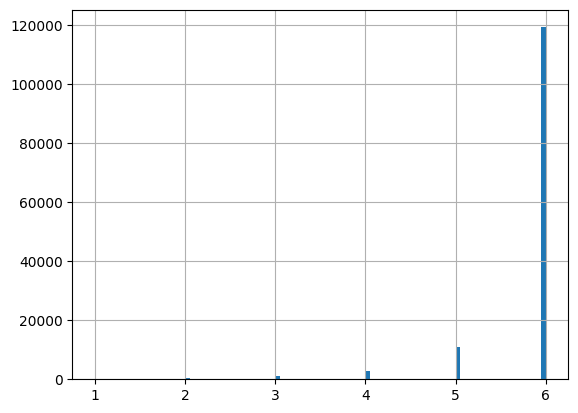

In [13]:
_ = pd.Series(question_counts).hist(bins=100)

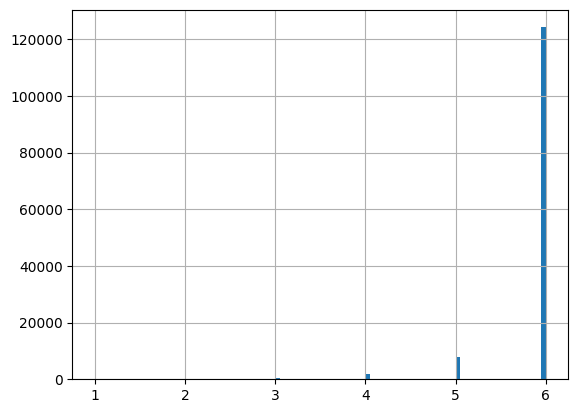

In [14]:
_ = pd.Series(imperative_counts).hist(bins=100)

In [15]:
len(extracted_data)

134591

In [16]:
sum(question_counts)

786353

In [17]:
sum(imperative_counts)

793143

In [18]:
# split to train and test data
random.shuffle(extracted_data)

test_data = extracted_data[:5000]
train_data = extracted_data[5000:]

In [19]:
# save train data
with gzip.GzipFile("./data/wikipedia-22-12-de-train-data.json.gz", "w") as f:
    f.write(json.dumps(train_data, indent=1).encode("utf-8"))

In [20]:
# save test data
with gzip.GzipFile("./data/wikipedia-22-12-de-test-data.json.gz", "w") as f:
    f.write(json.dumps(test_data, indent=1).encode("utf-8"))